# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal

### Import python packages

In [131]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from torch.optim import Adam

from ibov.utils import load_config
from ibov.model import train, torch_data, model_fc1h, model_fc2h, model_lstm, Model
from ibov.feature import create_lags, consolidate_features, create_delta_sign, label_train_test, Normalize
from ibov.request import get_history
from ibov.metrics import calculate_metrics, model_prediction, benchmark_model, graphical_evaluation

### Loading Configs

In [132]:
# Load config dict
config = load_config()

In [133]:
# Feature Engineering Configs
window = config.get("feature").get("window")
variables = config.get("feature").get("variables")
test_split = config.get("feature").get("split").get("test")
valid_split = config.get("feature").get("split").get("valid")

# Data Configs
data_dir = config.get("data").get("dir")
ibov_ticker = config.get("ibov").get("ticker")
filename = config.get("data").get("file")
data_size = config.get("data").get("size")
ascending = config.get("data").get("ascending") == 'True'

# Model configurations
dropout = config.get("model").get("dropout")
hidden_layer = config.get("model").get("hidden_layer")
lr = config.get("model").get("lr")
seed = config.get("model").get("seed")
epochs = config.get("model").get("epochs")

### Data Collection

In [129]:
import pandas as pd
from yahooquery import Ticker

def get_history(ticker, data_size, ascending):
     
    ticker = Ticker(symbols = ticker)
    history = ticker.history(period="max")
     
    df = history.sort_values(by="date", ascending=ascending)
         
    if ascending:
        df = df.tail(data_size).reset_index(drop=False)
    else:
        df = df.head(data_size).reset_index(drop=False)
          
    return df[["date", "close"]]  

def collect_data(stocks, data_size, ascending):
    
    stocks_df = get_history(stocks[0], data_size, ascending)[["date"]]
    
    for stock in stocks:
        stock_df = get_history(stock, data_size, ascending)
        stock_df.rename(columns={"close": stock[:-3]}, inplace=True)
        stocks_df = stocks_df.merge(stock_df, how="inner", on="date")
        
    return stocks_df

In [130]:
collect_data(stocks=config["ibov"]["stocks"], 
             data_size=config["data"]["size"], 
             ascending=config["data"]["ascending"])

,date,ITUB4,BBDC4
0,2019-08-06,35.490002,34.169998
1,2019-08-07,36.799999,34.889999
2,2019-08-08,37.000000,35.060001
3,2019-08-09,36.720001,34.480000
4,2019-08-12,35.200001,33.759998
...,...,...,...
360,2021-01-20,30.320000,25.850000
361,2021-01-21,29.910000,25.480000
362,2021-01-22,29.150000,24.990000
363,2021-01-26,28.250000,24.410000


#### Capture new data

In [65]:
# Target collection
ibovespa = get_history(ticker=ibov_ticker, data_size=data_size, ascending=ascending)

# Stock Prices
for stock in config["ibov"]["stocks"]:    
    df = get_history(ticker=stock, data_size=data_size, ascending=ascending)
    df.rename(columns={"close": stock[:-3]},inplace=True)
    ibovespa = ibovespa.merge(df, how="inner", on="date")
    
# Label datapoint as train or test dataset
ibovespa = label_train_test(ibovespa, split=test_split, split_valid=valid_split, ascending=ascending)

# Save data on disk
ibovespa.to_csv(os.path.join(data_dir, filename), index=False)

#### Read Existing data

In [66]:
# Read from disk
ibovespa = pd.read_csv(os.path.join(data_dir, filename))

### Data Exploration

It is important to evaluate data and get insights only form the train dataset. Otherwise, we will have a data leakage even before any model training.

In [5]:
explore_data = ibovespa[ibovespa["group"]=="train"]

# Calendar Variables
calendar_variables = pd.get_dummies(pd.DatetimeIndex(explore_data['date']).weekday, prefix="weekday")
explore_data = pd.concat([explore_data, calendar_variables], axis = 1)
explore_data[["weekday"]] = pd.DatetimeIndex(explore_data['date']).weekday

numeric_columns = ['close', 'ITUB4', 'BBDC4', 'VALE3', 'PETR4', 'PETR3', 'ABEV3', 'BBAS3', 'B3SA3', 'ITSA4']
stocks_diff = explore_data[numeric_columns].pct_change().reset_index(drop=True)
stocks_diff.columns = ["diff_" + column for column in stocks_diff.columns]

complete_explore_data = pd.concat([explore_data, stocks_diff], axis=1).iloc[1:].reset_index(drop=True)
complete_explore_data.head()

,date,close,ITUB4,BBDC4,VALE3,PETR4,PETR3,ABEV3,BBAS3,B3SA3,...,diff_close,diff_ITUB4,diff_BBDC4,diff_VALE3,diff_PETR4,diff_PETR3,diff_ABEV3,diff_BBAS3,diff_B3SA3,diff_ITSA4
0,2019-08-07,102782.0,36.799999,34.889999,46.480000,25.600000,28.200001,20.629999,48.450001,43.439999,...,0.006049,0.036912,0.021071,-0.003003,-0.010819,-0.009484,0.007324,-0.001031,0.014953,0.026066
1,2019-08-08,104115.0,37.000000,35.060001,47.180000,26.350000,28.870001,20.170000,48.799999,45.330002,...,0.012969,0.005435,0.004873,0.015060,0.029297,0.023759,-0.022298,0.007224,0.043508,0.010008
2,2019-08-09,103996.0,36.720001,34.480000,45.490002,26.280001,28.620001,20.070000,48.650002,45.500000,...,-0.001143,-0.007568,-0.016543,-0.035820,-0.002657,-0.008660,-0.004958,-0.003074,0.003750,-0.004573
3,2019-08-12,101915.0,35.200001,33.759998,45.160000,25.650000,27.850000,19.480000,47.000000,44.240002,...,-0.020010,-0.041394,-0.020882,-0.007254,-0.023973,-0.026904,-0.029397,-0.033916,-0.027692,-0.035222
4,2019-08-13,103299.0,35.889999,34.099998,46.500000,25.790001,27.959999,19.379999,47.549999,45.860001,...,0.013580,0.019602,0.010071,0.029672,0.005458,0.003950,-0.005133,0.011702,0.036618,0.025397


#### Weekday Boxplots

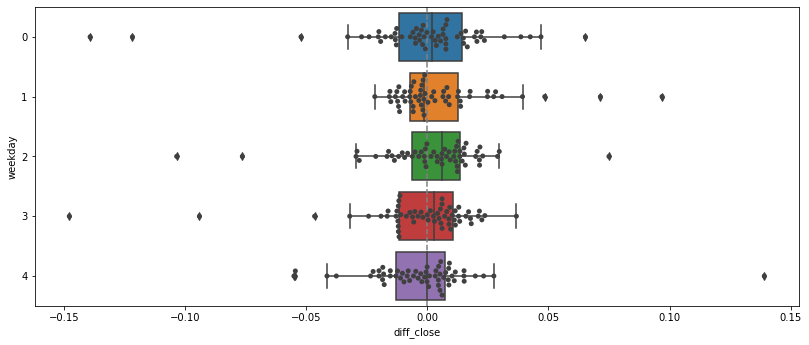

In [6]:
f, ax = plt.subplots(figsize=(13.7, 5.5))
sns.boxplot(y="weekday", x="diff_close", data=complete_explore_data, orient="h", ax=ax)
sns.swarmplot(x="diff_close", y="weekday", orient="h", data=complete_explore_data, color=".25", ax=ax)
plt.axvline(0, 0,1, ls="--", color="gray")

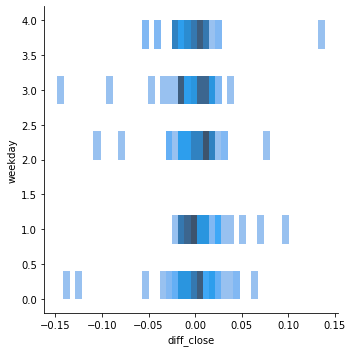

In [7]:
sns.displot(y="weekday", x="diff_close", data=complete_explore_data)

#### Correlations

In [24]:
last_day_diff = complete_explore_data.iloc[:-1][['diff_ITUB4', 'diff_BBDC4', 'diff_VALE3', 'diff_PETR4', 'diff_PETR3',
       'diff_ABEV3', 'diff_BBAS3', 'diff_B3SA3', 'diff_ITSA4']].reset_index(drop=True)

today_diff_close = complete_explore_data.iloc[1:][["diff_close"]].reset_index(drop=True)

diff_evaluation = pd.concat([today_diff_close, last_day_diff], axis=1)

In [13]:
diff_evaluation.corr(method="spearman")

,diff_close,diff_ITUB4,diff_BBDC4,diff_VALE3,diff_PETR4,diff_PETR3,diff_ABEV3,diff_BBAS3,diff_B3SA3,diff_ITSA4
diff_close,1.000000,-0.131339,-0.125016,-0.078830,-0.128111,-0.115125,-0.220664,-0.140016,-0.135050,-0.121671
diff_ITUB4,-0.131339,1.000000,0.885319,0.442513,0.581502,0.614077,0.507906,0.830265,0.573289,0.938893
diff_BBDC4,-0.125016,0.885319,1.000000,0.462029,0.610476,0.638683,0.537415,0.854447,0.587919,0.864577
diff_VALE3,-0.078830,0.442513,0.462029,1.000000,0.542041,0.566627,0.310748,0.450763,0.377983,0.445264
diff_PETR4,-0.128111,0.581502,0.610476,0.542041,1.000000,0.958942,0.436152,0.594731,0.506455,0.600646
diff_PETR3,-0.115125,0.614077,0.638683,0.566627,0.958942,1.000000,0.458117,0.620289,0.519341,0.630335
diff_ABEV3,-0.220664,0.507906,0.537415,0.310748,0.436152,0.458117,1.000000,0.476096,0.492217,0.510000
diff_BBAS3,-0.140016,0.830265,0.854447,0.450763,0.594731,0.620289,0.476096,1.000000,0.612529,0.823599
diff_B3SA3,-0.135050,0.573289,0.587919,0.377983,0.506455,0.519341,0.492217,0.612529,1.000000,0.611850
diff_ITSA4,-0.121671,0.938893,0.864577,0.445264,0.600646,0.630335,0.510000,0.823599,0.611850,1.000000


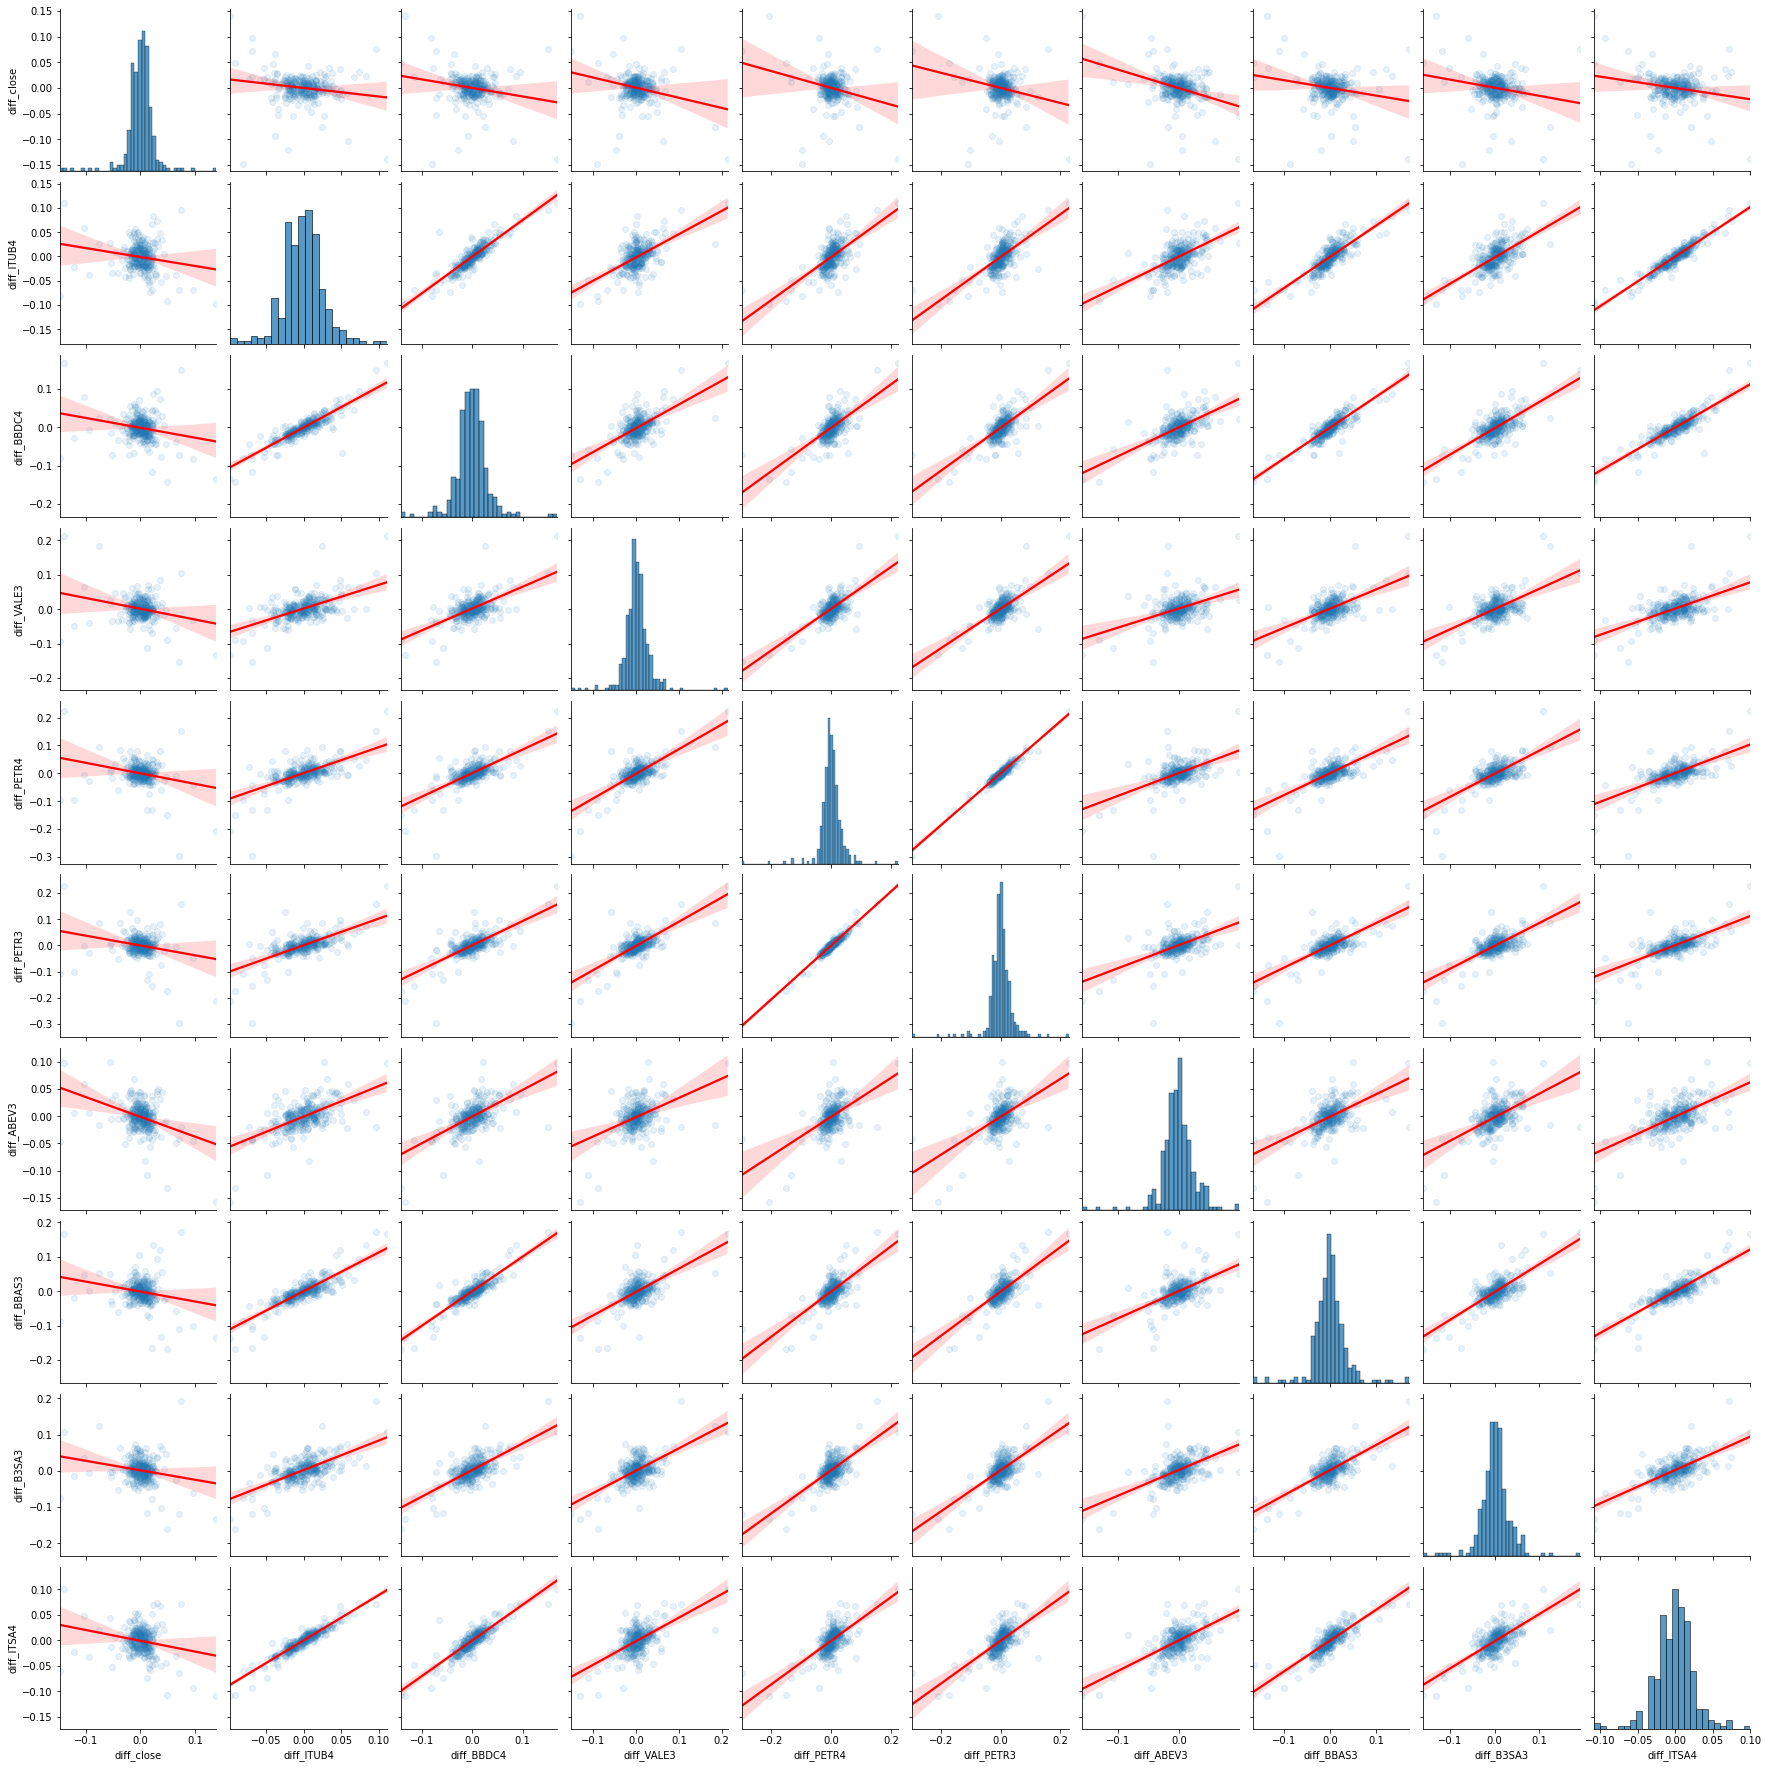

In [23]:
sns.pairplot(diff_evaluation, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

### Feature Engineering

In [ ]:
def feature_engineer(dados, config, mode, model=None):

    # Target Normalization

    scaler = Normalize()

    if mode == "train":
        scaler.fit(dados[dados["group"]=="train"][["close"]])
    elif mode == "predict":
        scaler.load_configs(maximo=model.maximo, minimo=model.minimo)
    else:
        raise Exception("mode does not exist")

    dados[["close"]] = scaler.transform(dados[["close"]])

    # Feature Engineering   

    ibov_lags_df = create_lags(dados, 
                               window=config["feature"]["window"], 
                               var="close", 
                               index="date")

    ibov_delta_sign_df = create_delta_sign(ibov_lags_df, 
                                           var="lags", 
                                           index="date", 
                                           window=config["feature"]["window"])

    master_table = consolidate_features(dados, "date", ibov_lags_df, ibov_delta_sign_df)

    return master_table, scaler

In [86]:
scaler = Normalize()
scaler.fit(ibovespa[ibovespa["group"]=="train"][["close"]])
ibovespa[["close"]] = scaler.transform(ibovespa[["close"]])

In [87]:
# Create lag variables
ibov_lags_df = create_lags(ibovespa, window=window, var="close", index="date")

In [88]:
# Create sign variables
ibov_delta_sign_df = create_delta_sign(ibov_lags_df, var="lags", index="date", window=window)

In [89]:
# Create weekdays dummies
weekdays_df = ibovespa[['date', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']]

In [90]:
# Create last day stock price diff variables
numeric_columns = ['close', 'ITUB4', 'BBDC4', 'VALE3', 'PETR4', 'PETR3', 'ABEV3', 'BBAS3', 'B3SA3', 'ITSA4']
stocks_diff = ibovespa[numeric_columns].pct_change().reset_index(drop=True)
diff_dates = ibovespa.iloc[2:][["date"]].reset_index(drop=True)
last_diff_df = stocks_diff.iloc[1:].iloc[:-1].reset_index(drop=True)
last_day_stock_diff = pd.concat([diff_dates, last_diff_df], axis=1)

In [98]:
last_day_stock_diff

,date,close,ITUB4,BBDC4,VALE3,PETR4,PETR3,ABEV3,BBAS3,B3SA3,ITSA4
0,2019-08-08,0.016013,0.036912,0.021071,-0.003003,-0.010819,-0.009484,0.007324,-0.001031,0.014953,0.026066
1,2019-08-09,0.033995,0.005435,0.004873,0.015060,0.029297,0.023759,-0.022298,0.007224,0.043508,0.010008
2,2019-08-12,-0.002935,-0.007568,-0.016543,-0.035820,-0.002657,-0.008660,-0.004958,-0.003074,0.003750,-0.004573
3,2019-08-13,-0.051477,-0.041394,-0.020882,-0.007254,-0.023973,-0.026904,-0.029397,-0.033916,-0.027692,-0.035222
4,2019-08-14,0.036093,0.019602,0.010071,0.029672,0.005458,0.003950,-0.005133,0.011702,0.036618,0.025397
...,...,...,...,...,...,...,...,...,...,...,...
358,2021-01-20,-0.009866,-0.011859,-0.016027,-0.002651,0.022088,0.012517,0.003083,-0.016977,-0.003454,-0.015477
359,2021-01-21,-0.016899,-0.016542,-0.020833,-0.018499,-0.016731,-0.016827,-0.015366,-0.022367,-0.009738,-0.015720
360,2021-01-22,-0.022534,-0.013522,-0.014313,0.011265,-0.023396,-0.018861,-0.025593,-0.010136,-0.031667,-0.020408
361,2021-01-26,-0.023163,-0.025410,-0.019231,-0.007819,-0.019238,-0.013884,-0.037156,-0.022235,0.006196,-0.019928


In [112]:
ement = create_lags(last_day_stock_diff, window=2, var="close", index="date")[["date", "lags"]].rename(columns={"lags": "close"})

In [113]:
# Consolidate raw data with features
master_table = consolidate_features(ibovespa[["date", "group"]], "date", 
                                    ibov_lags_df, ibov_delta_sign_df, ement, weekdays_df)

In [114]:
def torch_data(data, target, variables, group_var, batch, group):
    
    if group is not None:
        data  = data[data[group_var] == group].reset_index()
    
    x_tensor = torch.Tensor(data[variables].values.tolist())
    y_tensor = torch.Tensor(data[target])
    
    dataset = torch.utils.data.TensorDataset(x_tensor,y_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch)
    
    return loader, x_tensor, y_tensor

In [115]:
# Load data to torch standard
train_loader, train_x_tensor, train_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="train")

valid_loader, valid_x_tensor, valid_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="valid")

test_loader, test_x_tensor, test_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="test")

ValueError: expected sequence of length 1 at dim 2 (got 2)

### Training step

In [ ]:
from torch import nn
import torch

In [ ]:
class Model(nn.Module):

    def __init__(self, input_layer, hidden_layer=50, dropout=0.25):

        super(Model, self).__init__()
        self.hidden_layer = hidden_layer
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer+hidden_layer, 1)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer),
                            torch.zeros(1,1,self.hidden_layer))
        
        self.lstm = nn.LSTM(input_layer, hidden_layer)
        
    def forward(self, input):

        x = input[:,0,:]
        z = input[:,1,:]
        x = self.fc1(x)
        x = self.dropout(x)

        lstm_out, self.hidden_cell = self.lstm(z.view(len(z),1 , -1), self.hidden_cell)
        ds = torch.cat((x,lstm_out[:,0,:]),1)
        output = self.fc2(ds)

        return output

In [ ]:
# Model definition
model = Model(input_layer=window, hidden_layer=hidden_layer, dropout=dropout)
criterion = L1Loss()
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# Model training
train(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, seed=seed)

### Evaluation

In [ ]:
# Model performance on Training dataset
train_true, train_pred = model_prediction(model, train_x_tensor, train_y_tensor)
calculate_metrics(train_true, train_pred)

In [ ]:
# Model performance on Validation dataset
valid_true, valid_pred = model_prediction(model, valid_x_tensor, valid_y_tensor)
calculate_metrics(valid_true, valid_pred) 

In [ ]:
# Model performance on Test dataset
test_true, test_pred = model_prediction(model, test_x_tensor, test_y_tensor)
calculate_metrics(test_true, test_pred)

### Benchmark Model

In [ ]:
# Set and Evaludate Benchmark Model
bmk_true, bmk_pred = benchmark_model(test_y_tensor, valid_y_tensor)
calculate_metrics(bmk_true, bmk_pred)

### Graphical Evaluation

#### Test dataset and benchmark model

In [ ]:
# Evaluate test dataset graphically
graphical_evaluation(test_true, test_pred, bmk_true, bmk_pred)

#### Train and validation datasets

In [ ]:
# Evaluate train and validation dataset graphically
graphical_evaluation(train_true, train_pred, valid_true, valid_pred)